In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client

import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 

from statistics import mean
from matplotlib import style
from scipy import stats

style.use('default')
import matplotlib.path as mpath
import utils

import pandas as pd

### Get grid and case info

In [2]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
lons_norm = utils.normal_lons(lons)

In [3]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
path = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/'+case+'/ocn/proc/tseries/month_1/'

In [4]:
variables = ['photoC_TOT_zint_100m',
             'diatChl','spChl','coccoChl','diazChl','TEMP']

In [5]:
def preprocess(ds):
    ds=ds.isel(z_t=0)
    return ds

In [6]:
ds_fosi = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    #ds_tmp = xr.open_dataset(path+case+'.pop.h.'+var+'.??????-??????.nc')
    #ds_tmp['time'] = time
    
    files = sorted(glob(f'{path}/{case}.pop.h.{var}.??????-??????.nc'))       
    ds_tmp = xr.open_mfdataset(files, data_vars="minimal", coords='minimal', compat="override", parallel=True, concat_dim="time",
                       drop_variables=["transport_components", "transport_regions"], decode_times=True, preprocess=preprocess)

    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time','KMT'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
        
    ds_fosi = xr.merge([ds_fosi,ds_tmp])

starting on  photoC_TOT_zint_100m
starting on  diatChl
starting on  spChl
starting on  coccoChl
starting on  diazChl
starting on  TEMP


In [19]:
ds_fosi["time"] = ds_fosi.time_bound.compute().mean(dim="d2")

In [21]:
### trim to the satellite period since 2003

ds_fosi.time[540:768]

<xarray.DataArray 'time' (time: 228)>
array([cftime.DatetimeNoLeap(2003, 1, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2003, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2003, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2021, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2021, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2021, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 2003-01-16 12:00:00 ... 2021-12-16 12:00:00
    z_t      float32 500.0
Attributes:
    long_name:     boundaries for time-averaging interval
    cell_methods:  time: mean

In [22]:
### Now make a mean

ds_fosi = ds_fosi.isel(time=slice(540,768)).mean(dim='time')

In [24]:
ds_fosi['Chl']=(ds_fosi['diatChl'] + ds_fosi['spChl'] + ds_fosi['coccoChl'] + ds_fosi['diazChl'])

In [25]:
ds_fosi

<xarray.Dataset>
Dimensions:               (nlat: 384, nlon: 320, z_t_150m: 15)
Coordinates:
    TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    z_t                   float32 500.0
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    dz                    float32 dask.array<chunksize=(), meta=np.ndarray>
    photoC_TOT_zint_100m  (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    diatChl               (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 384, 320), meta=np.ndarray>
    spChl                 (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 384, 320), meta=np.ndarray>
    coccoChl              (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 384, 320), meta=np.ndarray>
    diazChl               (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 384, 320), meta=np.ndarray>
    TEMP                  (nlat, nlon) float32 dask.array<chunksize=(384, 320), meta=np.ndarray>
    Chl                   (z_t_150m, nlat, nlon) float32 dask.array<chunksize=(15, 384, 320), meta=np.ndarray>

### let's get SST from MODIS

In [26]:
def preprocess(ds):
    ds['lat'] = sat_lats
    ds['lon'] = sat_lons
    return ds

In [27]:
# %%time
# files = sorted(glob(f'/glade/work/kristenk/satellite_data/SST_annual/AQUA_MODIS.????????_????????.L3m.YR.SST.sst.9km.nc'))       
# ds_sat_sst = xr.open_mfdataset(files, concat_dim="time", combine='nested', preprocess=preprocess ).compute()

In [28]:
#tlen = 20
ny = 2160
nx = 4320

files = sorted(glob('/glade/work/kristenk/satellite_data/new_monthlySST/AQUA_MODIS.????????_????????.L3m.MO.SST.sst.9km.nc'))
tlen=len(files)

modis_sst = np.full((tlen,ny,nx),-9999.)

t = 0
for file in files:
    ds_tmp = xr.open_dataset(file)
    modis_sst[t,:,:] = np.flipud(ds_tmp.sst.values)
    t = t + 1

modis_sst = xr.DataArray(modis_sst, dims=('time','lat','lon'))

ds_sat_sst = xr.Dataset()
ds_sat_sst['sst'] = modis_sst

In [29]:
lat_data = np.arange(-90+1/24,90,1/12)
lon_data = np.arange(-180+1/24,180,1/12)

In [30]:
ds_sat_sst['lat']= lat_data
ds_sat_sst['lon']= lon_data

In [31]:
ds_sat_sst['time'] = pd.date_range(start='2002-08-01', end='2022-09-01',freq="M")

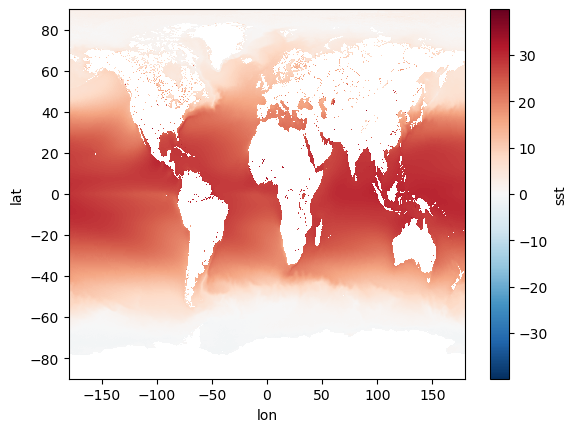

In [36]:
ds_sat_sst.mean(dim='time').sst.plot()

In [37]:
ds_sat_sst = ds_sat_sst.mean(dim='time')

### let's get a chlorophyll  from MODIS

In [38]:
tlen = 18
ny = 2160
nx = 4320

files = sorted(glob('/glade/work/kristenk/satellite_data/Chl_annual/A??????????????.L3m_YR_CHL_chlor_a_9km.nc'))
tlen=len(files)

modis_chl = np.full((tlen,ny,nx),-9999.)

t = 0
for file in files:
    ds_tmp = xr.open_dataset(file)
    modis_chl[t,:,:] = np.flipud(ds_tmp.chlor_a.values)
    t = t + 1

modis_chl = xr.DataArray(modis_chl, dims=('time','lat','lon'))

ds_sat_chl = xr.Dataset()
ds_sat_chl['chl'] = modis_chl

In [39]:
lat_data = np.arange(-90+1/24,90,1/12)
lon_data = np.arange(-180+1/24,180,1/12)

In [40]:
ds_sat_chl['lat'] = lat_data
ds_sat_chl['lon'] = lon_data

In [41]:
ds_sat_chl['time'] = np.arange(2003,2021,1)

In [42]:
ds_sat_chl = ds_sat_chl.mean(dim='time')

### Get NPP

In [43]:
import pandas as pd

In [44]:
%%time
files = sorted(glob(f'/glade/work/kristenk/satellite_data/VGPM/netcdf/vgpm.???????.all.nc'))       
ds_vgpm = xr.open_mfdataset(files, concat_dim="time", combine='nested',).compute()

CPU times: user 4.41 s, sys: 8.01 s, total: 12.4 s
Wall time: 59.7 s


In [45]:
ds_vgpm = ds_vgpm.where(ds_vgpm > -9999.)

In [46]:
time = pd.date_range(start="2003-01-01", end="2022-01-01",freq="M")

In [47]:
ds_vgpm = ds_vgpm.mean(dim='time')

In [54]:
ds_vgpm.NPP

<xarray.DataArray 'NPP' (lat: 2160, lon: 4320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lon      (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat      (lat) float64 -89.96 -89.88 -89.79 -89.71 ... 89.79 89.88 89.96
Attributes:
    units:      mgC m$^{-2}$ d$^{-1}$
    long_name:  Net primary production

### Now plot it all together!

In [49]:
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cmocean

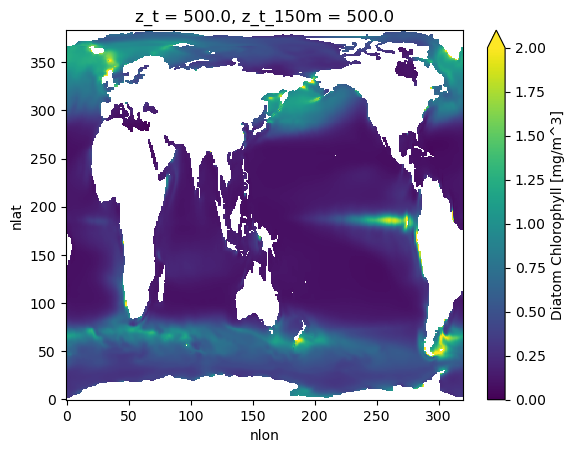

In [56]:
ds_fosi.Chl.isel(z_t_150m=0).plot(vmin=0,vmax=2)

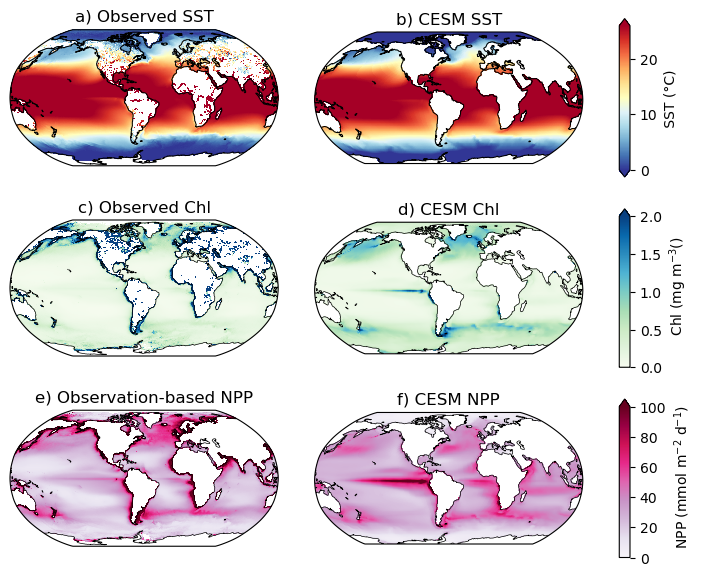

In [61]:
fig = plt.figure(figsize=(8, 7))
gs = gridspec.GridSpec(nrows=3, ncols=3, width_ratios=(1, 1, 0.04))

prj = ccrs.Robinson(central_longitude=305.0)

ax_sst_sat = plt.subplot(gs[0, 0], projection=prj)
ax_sst_cesm = plt.subplot(gs[0, 1], projection=prj)
ax_chl_sat = plt.subplot(gs[1, 0], projection=prj)
ax_chl_cesm = plt.subplot(gs[1, 1], projection=prj)
ax_npp_sat = plt.subplot(gs[2, 0], projection=prj)
ax_npp_cesm = plt.subplot(gs[2, 1], projection=prj)

cax_sst = plt.subplot(gs[0, 2])
cax_chl = plt.subplot(gs[1, 2])
cax_npp = plt.subplot(gs[2, 2])
#########################

ax_sst_sat.set_title('a) Observed SST', fontsize=12)
pc_sst_sat=ax_sst_sat.pcolormesh(ds_sat_sst.lon, ds_sat_sst.lat, ds_sat_sst.sst, 
                     cmap='RdYlBu_r',vmin=0, vmax=26,
                     transform=ccrs.PlateCarree())
ax_sst_sat.coastlines('110m',linewidth=0.75)

ax_sst_cesm.set_title('b) CESM SST', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_fosi.TEMP)
ax_sst_cesm.coastlines('110m',linewidth=0.75)
pc_sst_cesm=ax_sst_cesm.pcolormesh(lon, lat, field, 
                 cmap='RdYlBu_r',vmin=0, vmax=26,
                    transform=ccrs.PlateCarree())

#######################

ax_chl_sat.set_title('c) Observed Chl', fontsize=12)
pc_chl_sat=ax_chl_sat.pcolormesh(ds_sat_chl.lon, ds_sat_chl.lat, ds_sat_chl.chl.squeeze(),
                                 cmap='GnBu',vmin=0, vmax=2,transform=ccrs.PlateCarree())
ax_chl_sat.coastlines('110m',linewidth=0.5)

ax_chl_cesm.set_title('d) CESM Chl', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi.Chl.isel(z_t_150m=0)) #convert from µmol/kg to mmol/m3
pc_chl_cesm=ax_chl_cesm.pcolormesh(lon, lat, field, 
                                     cmap='GnBu',vmin=0, vmax=2,
                                     transform=ccrs.PlateCarree())
ax_chl_cesm.coastlines('110m',linewidth=0.5)


#######################

ax_npp_sat.set_title('e) Observation-based NPP', fontsize=12)
pc_npp_sat=ax_npp_sat.pcolormesh(ds_vgpm.lon, ds_vgpm.lat, ds_vgpm.NPP/12,
                                 cmap='PuRd',vmin=0, vmax=100,transform=ccrs.PlateCarree())
ax_npp_sat.coastlines('110m',linewidth=0.5)

ax_npp_cesm.set_title('f) CESM NPP', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_fosi.photoC_TOT_zint_100m * 0.01 * 86400.)
pc_npp_cesm=ax_npp_cesm.pcolormesh(lon, lat, field, 
                                     cmap='PuRd',vmin=0, vmax=100,
                                     transform=ccrs.PlateCarree())
ax_npp_cesm.coastlines('110m',linewidth=0.5)

############################

cb_sst = plt.colorbar(pc_sst_cesm, cax=cax_sst,extend='both', label=' SST (°C) ')
cb_chl = plt.colorbar(pc_chl_cesm, cax=cax_chl,extend='max', label=' Chl (mg m$^{-3}$()')
cb_npp = plt.colorbar(pc_npp_cesm, cax=cax_npp,extend='max', label=' NPP (mmol m$^{-2}$ d$^{-1}$)')

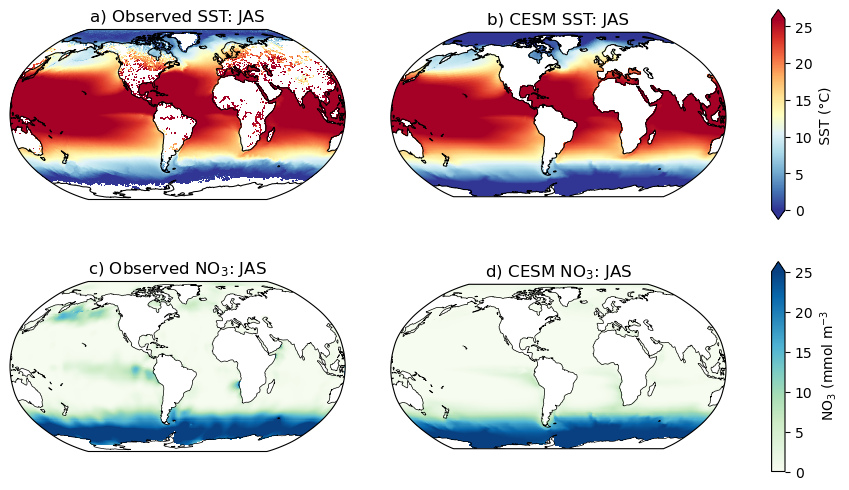

In [26]:
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(nrows=2, ncols=3, width_ratios=(1, 1, 0.04))

prj = ccrs.Robinson(central_longitude=305.0)

ax_sst_sat = plt.subplot(gs[0, 0], projection=prj)
ax_sst_cesm = plt.subplot(gs[0, 1], projection=prj)
ax_no3_sat = plt.subplot(gs[1, 0], projection=prj)
ax_no3_cesm = plt.subplot(gs[1, 1], projection=prj)

cax_sst = plt.subplot(gs[0, 2])
cax_no3 = plt.subplot(gs[1, 2])

#########################

ax_sst_sat.set_title('a) Observed SST: JAS', fontsize=12)
pc_sst_sat=ax_sst_sat.pcolormesh(ds_jas_sat.lon, ds_jas_sat.lat, ds_jas_sat.sst, 
                     cmap='RdYlBu_r',vmin=0, vmax=26,
                     transform=ccrs.PlateCarree())
ax_sst_sat.coastlines('110m',linewidth=0.75)

ax_sst_cesm.set_title('b) CESM SST: JAS', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats,  ds_jas.TEMP)
ax_sst_cesm.coastlines('110m',linewidth=0.75)
pc_sst_cesm=ax_sst_cesm.pcolormesh(lon, lat, field, 
                 cmap='RdYlBu_r',vmin=0, vmax=26,
                    transform=ccrs.PlateCarree())

#######################

ax_no3_sat.set_title('c) Observed NO$_3$: JAS', fontsize=12)
pc_no3_sat=ax_no3_sat.pcolormesh(ds_woa_jas.lon, ds_woa_jas.lat, ds_woa_jas.n_an.isel(depth=0).squeeze(),
                                 cmap='GnBu',vmin=0, vmax=25,transform=ccrs.PlateCarree())
ax_no3_sat.coastlines('110m',linewidth=0.5)

ax_no3_cesm.set_title('d) CESM NO$_3$: JAS', fontsize=12)
lon, lat, field = utils.adjust_pop_grid(lons, lats, ds_jas.NO3 * 1.026) #convert from µmol/kg to mmol/m3
pc_no3_cesm=ax_no3_cesm.pcolormesh(lon, lat, field, 
                                     cmap='GnBu',vmin=0, vmax=25,
                                     transform=ccrs.PlateCarree())
ax_no3_cesm.coastlines('110m',linewidth=0.5)

############################

cb_sst = plt.colorbar(pc_sst_cesm, cax=cax_sst,extend='both', label=' SST (°C) ')
cb_no3 = plt.colorbar(pc_no3_cesm, cax=cax_no3,extend='max', label=' NO$_3$ (mmol m$^{-3}$')
